In [1]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np

ROOT_PATH = "training/data/cut_video"
TF_RECORD_FILE = "training/cup_dataset.tfrecord"

In [2]:
def xml_to_df(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

def group_by_image(path, df):
    for img_file in glob.glob(path + "/*.png"):
        filename = os.path.basename(img_file)
        img = cv2.imread(img_file,1)
        
        detections = [[row.ymin, row.xmin, row.ymax, row.xmax] for _,row in df.loc[df['filename'] == filename].iterrows()]
        
        yield {'img': img, 'detections': detections, 'filename': filename}

        
df = xml_to_df(ROOT_PATH + "/annotations")

[sample['filename'] for sample in group_by_image(ROOT_PATH,df) if len(sample['detections']) == 0]

['frame_14.png',
 'frame_28.png',
 'frame_27.png',
 'frame_15.png',
 'frame_1.png',
 'frame_29.png',
 'frame_46.png',
 'frame_2.png',
 'frame_4.png',
 'frame_3.png']

In [3]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

writer = tf.python_io.TFRecordWriter(TF_RECORD_FILE)

for sample in group_by_image(ROOT_PATH,df):
    
    height = sample['img'].shape[0]
    width = sample['img'].shape[1]
    
    nparrDetections = np.array(sample['detections'])
    
    detections = [nparrDetections.tostring()]
    example = tf.train.Example(features=tf.train.Features(feature={
        'detections': tf.train.Feature(bytes_list=tf.train.BytesList(value=detections)),
        'detections_count': _int64_feature(nparrDetections.shape[0]),
        'image_raw': _bytes_feature(sample['img'].tostring()),
        'height': _int64_feature(height),
        'width': _int64_feature(width),
    }))
    
    writer.write(example.SerializeToString())

writer.close()

# Read for training

In [2]:
def read_and_decode(filename_queue, IMAGE_TARGET_SIZE=(1024, 720)):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'detections_count': tf.FixedLenFeature([], tf.int64),
        'detections': tf.FixedLenFeature([], tf.string),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    #detections = tf.decode_raw(features['detections'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    detections_count = tf.cast(features['detections_count'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    #detections_shape = tf.stack([detections_count, 4])
    
    image = tf.reshape(image, image_shape)
    #detections = tf.reshape(detections, detections_shape)
    
    image_size_const = tf.constant((IMAGE_TARGET_SIZE[0], IMAGE_TARGET_SIZE[1], 3), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_TARGET_SIZE[0],
                                           target_width=IMAGE_TARGET_SIZE[1])
    
    #todo: resize detection
    
    
    images, detections = tf.train.shuffle_batch( [resized_image, detections_count],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, detections

[1 1]


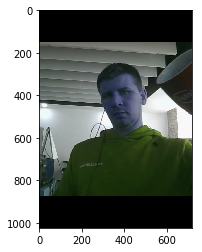

[0 0]


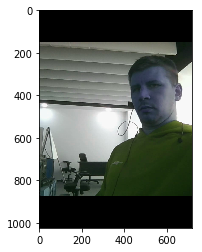

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: shuffle_batch_1/random_shuffle_queue_enqueue = QueueEnqueueV2[Tcomponents=[DT_UINT8, DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](shuffle_batch_1/random_shuffle_queue, Squeeze_1, Cast_5)]]


In [5]:

filename_queue = tf.train.string_input_producer(
    [TF_RECORD_FILE], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, detections = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(2):
        img, detect = sess.run([image, detections])
        
        print(detect)
        
        plt.imshow(img[0, :, :, :])
        plt.show()

In [11]:
np.zeros((1,3), dtype='uint8')

array([[0, 0, 0]], dtype=uint8)